# 데이터 불러오기

In [1]:
import os
os.chdir('../data')

In [2]:
import pandas as pd
df = pd.read_csv('전처리완료.csv', encoding='CP949')
reviews = pd.read_csv('campaign_reviews.csv', encoding='utf-8')

df.shape, reviews.shape

C:\Users\samsung\AppData\Local\Temp\ipykernel_11976\1979794408.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('전처리완료.csv', encoding='CP949')


((186025, 47), (25249, 2))

# EDA

- 캠페인은 전체 주문 건 중 얼마나 차지하는지

In [4]:
bold = '\033[1m'
end = '\033[0m'
tab = df.copy()
tab['연도'] = df['구매일'].str.split('-').str[0]
tab = tab[tab['연도'] == '2022']

hug = df[df['상품명_정제'].str.contains('허그박스', na=False)].shape[0] 

print(f'{bold}2022년 매출 :{end} {tab['결제금액'].sum()} 원')
print(f'전체 데이터 중 허그박스 주문 건수 비율 : {bold}{hug / df.shape[0]* 100:.2f}%{end}로 {bold}{hug}{end}건 입니다.')

2022년 매출 : 2921897358.0 원
전체 데이터 중 허그박스 주문 건수 비율 : 5.96%로 11090건 입니다.


- 캠페인 후기 작성글 중, SNS 후기글까지 작성한 비율

In [12]:
from IPython.display import HTML, display

blog = reviews[reviews.content.str.contains('blog', na=False)].shape[0] / reviews.shape[0]
insta = reviews[reviews.content.str.contains('insta', na=False)].shape[0] / reviews.shape[0]
http = reviews[reviews.content.str.contains('http', na=False)].shape[0] / reviews.shape[0]

display(HTML(f'블로그 작성비율 : <b>{blog*100:.1f}%</b>'))
display(HTML(f'인스타 작성비율 : <b>{insta*100:.1f}%</b>'))
display(HTML(f'모든 SNS 작성비율 : <b>{http*100:.1f}%</b>'))

- 캠페인으로 유입된 고객의 재구매 전환율

In [6]:
cond = df['상품명_정제'].str.contains('허그박스', na=False)
허그박스결제건 =  df[cond].reset_index(drop=True)
허그박스_고객번호 = 허그박스결제건['고객번호'].unique()

print('허그박스 재구매 전환율')

# 허그박스 구매한 경험이 있는 고객들만 필터링
허그박스 = df[df['고객번호'].isin(허그박스_고객번호)]

# 2회 이상 구매한 고객 수
재구매_횟수 = 허그박스.groupby('고객번호')['주문번호'].size()
허그박스재구매자수 = 재구매_횟수[재구매_횟수 > 1].count()

허그박스구매자수 = df['상품명_정제'].str.contains('허그박스', na=False).sum()

# 재구매 전환율 계산
전환율 = 허그박스재구매자수 / 허그박스구매자수 * 100

# 출력
print(f"전체 허그박스 구매자 수: {허그박스구매자수:,}명")
print(f"재구매한 고객 수(2회 이상): {허그박스재구매자수:,}명")
print(f"재구매 전환율: {전환율:.2f}%")

허그박스 재구매 전환율
전체 허그박스 구매자 수: 11,073명
재구매한 고객 수(2회 이상): 2,794명
재구매 전환율: 25.23%


In [18]:
# 허그박스 구매 시점과 재구매 시점 구분
허그박스_첫구매 = 허그박스[허그박스['상품명_정제'].str.contains('허그박스', na=False)]
허그박스_재구매 = 허그박스[~허그박스['상품명_정제'].str.contains('허그박스', na=False)]

# 분석할 범주형 컬럼 반복
for col in ['고객등급']:   # 하나라도 리스트로 넣는 것이 안전
    print(f'\n[{col}]')

    # ── ① 두 그룹의 범주별 비율 계산 ──
    vc_hug = 허그박스_첫구매[col].value_counts(normalize=True)
    vc_not = 허그박스_재구매[col].value_counts(normalize=True)

    # ── ② 범주 인덱스 정렬 & 좌우 결합 ──
    summary = pd.concat(
        [vc_hug, vc_not],
        axis=1,
        keys=['허그박스 구매시', '재구매자']
    ).fillna(0)

    # ── ③ 퍼센트 변환 ──
    summary = (summary * 100).round(2)

    # ── ④ 보기 좋게 정렬하여 출력 ──
    display(summary.sort_index())


[고객등급]


,허그박스 구매시,재구매자
고객등급,,
골드,7.80,33.96
다이아몬드,1.08,9.73
브론즈,0.41,1.97
스타,0.10,0.90
실버,87.91,35.52
플래티넘,2.70,17.92


- 캠페인 유입 고객의 첫구매, 첫구매 이후 고객 등급 변화

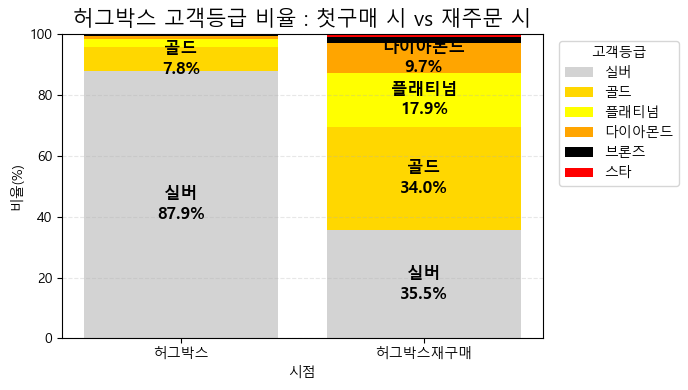

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))

bottoms = [0] * summary.shape[0]
x_labels = summary.index.tolist()

for idx, col in enumerate(summary.columns):
    values = summary[col].values
    bars = ax.bar(x_labels, values, bottom=bottoms, color=pastel_colors[idx], label=col)

    for bar, val in zip(bars, values):
        if val > 5:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{col}\n{val:.1f}%",
                ha='center', va='center',
                fontsize=12, fontweight='bold',
                color='white' if idx >= 4 else 'black'
            )

    bottoms = [b + v for b, v in zip(bottoms, values)]

ax.set_title('허그박스 고객등급 비율 : 첫구매 시 vs 재주문 시',fontsize=15)
ax.set_ylabel('비율(%)')
ax.set_xlabel('시점')
ax.set_ylim(0, 100)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
ax.legend(title='고객등급', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

- 가설 : 허그박스로 유입된 고객은 이탈율이 더 적을 것이다.

In [19]:
허그박스고객데이터 = df[df['고객번호'].isin(허그박스_고객번호)]

# 허그박스 구매 시점과 재구매 시점 구분
허그박스_첫구매 = 허그박스고객데이터[허그박스고객데이터['상품명_정제'].str.contains('허그박스', na=False)]
허그박스_재구매 = 허그박스고객데이터[~허그박스고객데이터['상품명_정제'].str.contains('허그박스', na=False)]

# 분석할 범주형 컬럼 반복
for col in ['이탈등급']:   # 하나라도 리스트로 넣는 것이 안전
    print(f'\n[{col}]')

    # ── ① 두 그룹의 범주별 비율 계산 ──
    vc_hug = 허그박스_첫구매[col].value_counts(normalize=True)
    vc_not = 허그박스_재구매[col].value_counts(normalize=True)

    # ── ② 범주 인덱스 정렬 & 좌우 결합 ──
    summary = pd.concat(
        [vc_hug, vc_not],
        axis=1,
        keys=['허그박스 구매시', '재구매자']
    ).fillna(0)

    # ── ③ 퍼센트 변환 ──
    summary = (summary * 100).round(2)

    # ── ④ 보기 좋게 정렬하여 출력 ──
    display(summary.sort_index())


[이탈등급]


,허그박스 구매시,재구매자
이탈등급,,
이탈,25.57,2.76
활성화고객,7.32,44.42
휴면 고객,59.18,25.23
휴면예비군,7.94,27.60


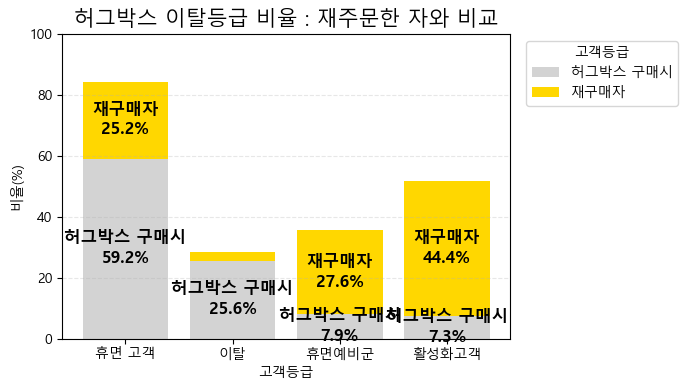

In [22]:
fig, ax = plt.subplots(figsize=(7, 4))

bottoms = [0] * summary.shape[0]
x_labels = summary.index.tolist()

for idx, col in enumerate(summary.columns):
    values = summary[col].values
    bars = ax.bar(x_labels, values, bottom=bottoms, color=pastel_colors[idx], label=col)

    for bar, val in zip(bars, values):
        if val > 5:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{col}\n{val:.1f}%",
                ha='center', va='center',
                fontsize=12, fontweight='bold',
                color='white' if idx >= 4 else 'black'
            )

    bottoms = [b + v for b, v in zip(bottoms, values)]

ax.set_title('허그박스 이탈등급 비율 : 재주문한 자와 비교',fontsize=15)
ax.set_ylabel('비율(%)')
ax.set_xlabel('고객등급')
ax.set_ylim(0, 100)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
ax.legend(title='고객등급', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

- 가설 : 허그박스 주문은 출생아수와 연관이 있을 것이다.  
뉴스 기사에 따르면 해당 캠페인은 연간 출생아수의 60%가 참여하는 것으로 알려짐  
허그박스는 임신 중 ~ 출산 3개월 이내 산모를 대상으로 제공 중임

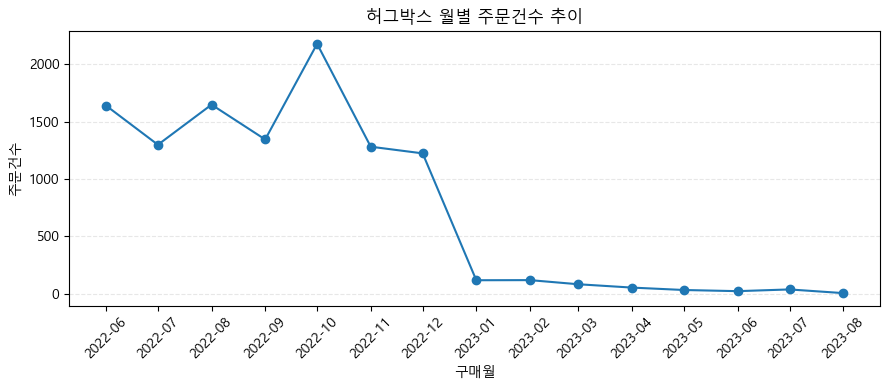

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'

# 1) 허그박스 필터링
tab = df[df['상품명_정제'].str.contains('허그박스', na=False)].copy()

# 2) 구매일 전처리 (월 단위로 그룹핑)
tab['구매일'] = (
    pd.to_datetime(tab['구매일'], errors='coerce')     # 날짜형 변환
      .dt.to_period('M')                               # 2025-06 형태
      .dt.to_timestamp()                               # 다시 Timestamp로 변환
)

# 3) 월별 주문건수 집계
tab = tab.groupby('구매일')['주문번호'].size().reset_index(name='주문건수')

# 4) 시각화
plt.figure(figsize=(9, 4))
plt.plot(tab['구매일'], tab['주문건수'], marker='o')

plt.title('허그박스 월별 주문건수 추이')
plt.xlabel('구매월')
plt.ylabel('주문건수')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 월 단위 눈금 포맷 설정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

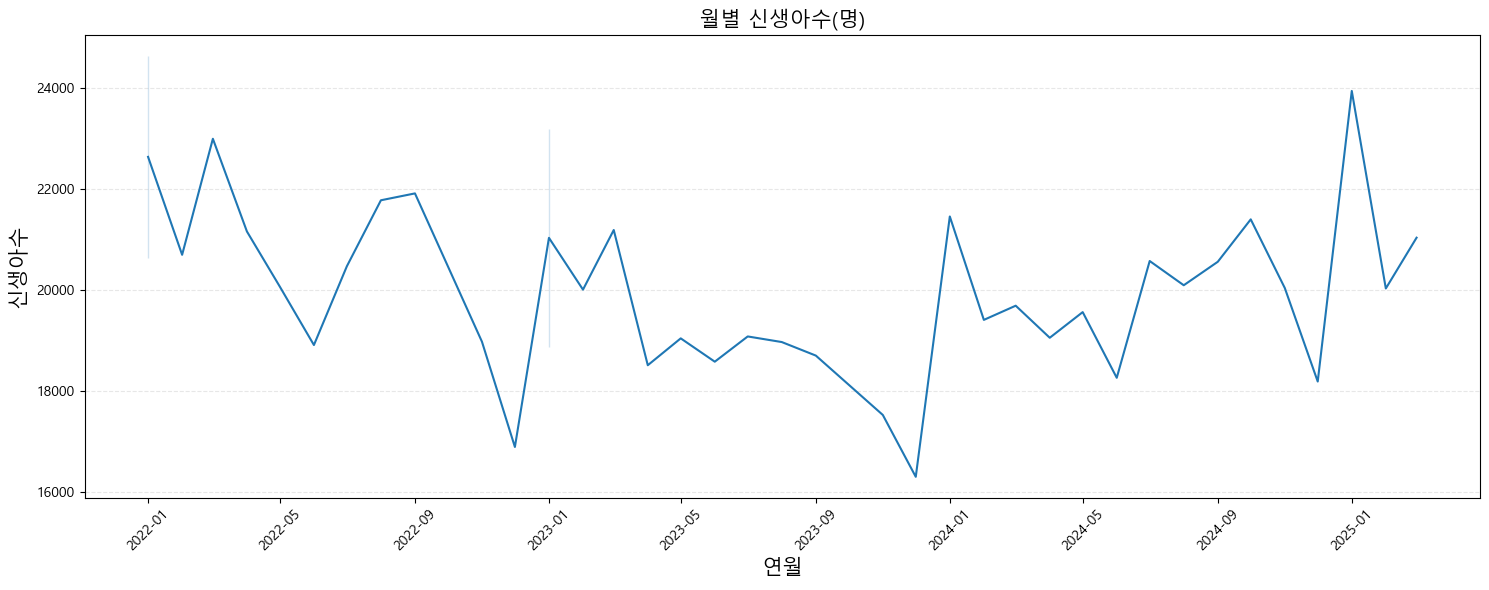

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

출생 = pd.read_csv('출생률.csv', encoding='CP949')

출생.columns = ['연월', '2022.01', '2022.02', '2022.03', '2022.04', '2022.05', '2022.06',
       '2022.07', '2022.08', '2022.09', '2022.1', '2022.11', '2022.12',
       '2023.01', '2023.02', '2023.03', '2023.04', '2023.05', '2023.06',
       '2023.07', '2023.08', '2023.09', '2023.1', '2023.11', '2023.12',
       '2024.01', '2024.02', '2024.03', '2024.04', '2024.05',
       '2024.06', '2024.07', '2024.08', '2024.09', '2024.10',
       '2024.11', '2024.12', '2025.01', '2025.02', '2025.03']

출생 = 출생.T.reset_index()
출생.columns = ['구매일', '신생아수']
출생 = 출생.drop(index=0)

출생['구매일'] = pd.to_datetime(출생['구매일'], format='%Y.%m')

# 시각화
plt.figure(figsize=(15, 6))
sns.lineplot(data=출생, x='구매일', y='신생아수')
plt.title('월별 신생아수(명)', fontsize=15)
plt.xlabel('연월', fontsize=15)
plt.ylabel('신생아수', fontsize=15)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
tab = (
    df[df['상품명_정제'].str.contains('허그박스', na=False)]
      .assign(구매일=lambda d: pd.to_datetime(d['구매일'], errors='coerce')
                              .dt.to_period('M')
                              .dt.to_timestamp())
      .groupby('구매일')['주문번호']
      .size()
      .reset_index(name='주문건수')
)

new_tab = (
    출생
    .merge(tab, on='구매일', how='left')
    .sort_values('구매일')
    .fillna({'주문건수': 0})
)

# 출생아수 +3개월 이동
new_tab['출생아수(+3M)'] = new_tab['신생아수'].shift(3)

# 주문건수 0 제외하고 시각화용 데이터 구성
plot_tab = new_tab[new_tab['주문건수'] > 0]

df[df['상품명_정제'].str.contains('허그박스', na=False)]['구매시월령'].describe()

count    11073.000000
mean         0.184954
std         11.187056
min         -9.000000
25%         -3.000000
50%         -1.000000
75%          0.000000
max        238.000000
Name: 구매시월령, dtype: float64

- 보통 허그박스를 출산 3개월전 ~ 출산할 쯤에 주문하는 편
- 따라서 출산 1~3개월 전과 출생아수와 연관성을 분석하고자 함  

In [54]:
corrs = {}
for m in (1, 2, 3):
    col = f'출생아수(+{m}M)'
    plot_tab[col] = plot_tab['신생아수'].shift(m)
    # 주문건수와 시프트된 출생아 수의 피어슨 r
    corrs[m] = plot_tab[['주문건수', col]].corr().iloc[0, 1]

print(corrs)
best_m = max(corrs, key=lambda k: abs(corrs[k]))
print(f'▶ 가장 겹치는 시프트: +{best_m}개월')

{1: 0.2877961253889306, 2: 0.298317539613317, 3: 0.12094734129753854}
▶ 가장 겹치는 시프트: +2개월


C:\Users\campus4D035\AppData\Local\Temp\ipykernel_40640\3924825237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_tab[col] = plot_tab['신생아수'].shift(m)
C:\Users\campus4D035\AppData\Local\Temp\ipykernel_40640\3924825237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_tab[col] = plot_tab['신생아수'].shift(m)
C:\Users\campus4D035\AppData\Local\Temp\ipykernel_40640\3924825237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

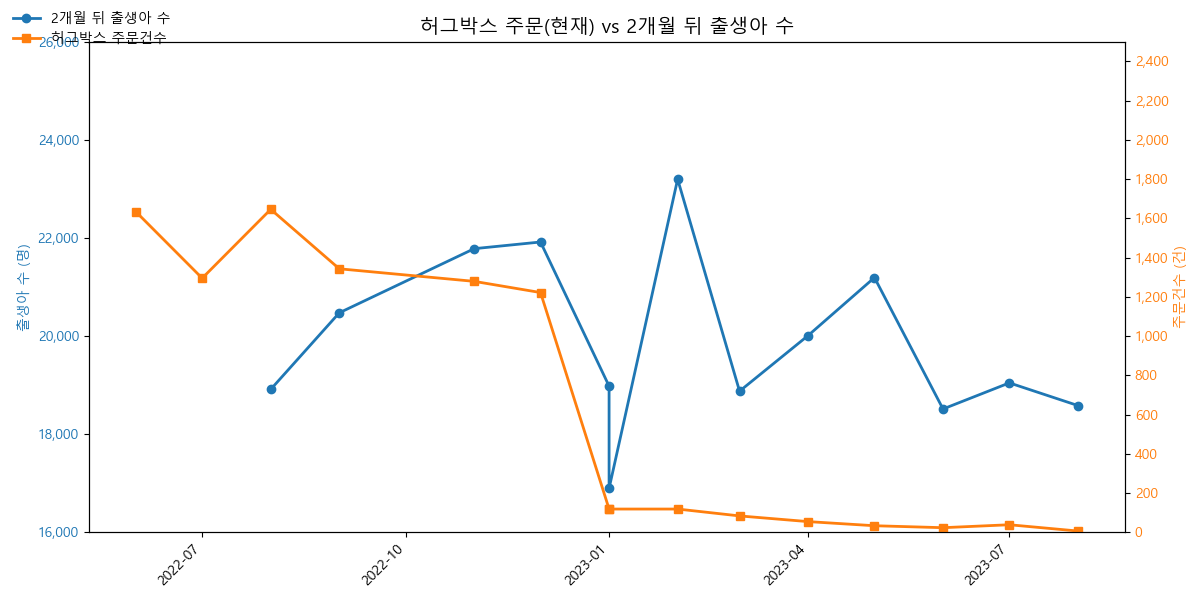

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MultipleLocator
best_m = 2
# ───── plot_tab 은 앞서 만들었던 DataFrame 그대로 사용 ─────
fig, ax1 = plt.subplots(figsize=(12, 6))

# ▸ (m 개월 뒤) 출생아 수 ─ 왼쪽 y축
ax1.plot(plot_tab['구매일'],
         plot_tab[f'출생아수(+{best_m}M)'],
         color='tab:blue', marker='o', linewidth=2,
         label=f'{best_m}개월 뒤 출생아 수')

ax1.set_ylabel('출생아 수 (명)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ▸ y축 범위·눈금
ax1.set_ylim(16_000, 26_000)               # 범위
ax1.yaxis.set_major_locator(MultipleLocator(2_000))   # 2 000 단위 눈금
ax1.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')        # 천 단위 콤마
)

# ▸ 허그박스 주문건수 ─ 오른쪽 y축
ax2 = ax1.twinx()
ax2.plot(plot_tab['구매일'],
         plot_tab['주문건수'],
         color='tab:orange', marker='s', linewidth=2,
         label='허그박스 주문건수')

ax2.set_ylabel('주문건수 (건)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# ▸ 오른쪽 y축 범위·눈금
ax2.set_ylim(0,2500)
ax2.yaxis.set_major_locator(MultipleLocator(200))     # 200 단위 눈금
ax2.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'{int(x):,}')
)

# ───── x축 & 제목 등은 동일 ─────
ax1.set_title(f'허그박스 주문(현재) vs {best_m}개월 뒤 출생아 수', fontsize=14)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate(rotation=45)

# 범례
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
fig.legend(h1 + h2, l1 + l2, loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


- 출생 신생아수와 허그박스 주문수를 매칭하려고 했지만, 샘플링된 데이터라 정확한 확인은 어려움
- 하지만 출생아수 급감, 허그박스 주문건이 급감한 시점은 일치했음

In [2]:
허그박스 = df[df['고객번호'].isin(허그박스_고객번호)]
허그박스_미구매자     = df[~df['고객번호'].isin(허그박스_고객번호)]

cols = (
    '구매시월령_bin 물품대분류 성별 결혼유무 거주지역 결제등록카드 유입경로 자녀여부 '
    '기저귀단계 남아여아공용 브랜드 원플원 핫딜 쿠폰적용가강조 무료배송강조 증정강조 '
    '예약구매 기저귀밴드/팬티 아이정보건너뛰기 고객등급 이탈등급'
).split()

for col in cols:
    print(f'\n[{col}]')
    
    # ── ① 두 그룹의 범주별 비율 계산 ──
    vc_hug = 허그박스[col].value_counts(normalize=True)
    vc_not = 허그박스_미구매자[col].value_counts(normalize=True)
    
    # ── ② 범주 인덱스 정렬 & 좌우 결합 ──
    summary = pd.concat(
        [vc_hug, vc_not],
        axis=1,
        keys=['허그박스', '미구매자']   # 열 이름 두 개!  순서와 개수 맞추기
    ).fillna(0)                       # 한쪽에만 있는 범주는 0으로
    
    # ── ③ 퍼센트(선택) ──
    summary = (summary * 100).round(2)   # 0–1 → 0–100 %
    
    display(summary.sort_index())        # 범주 순서대로 보기 좋게


[구매시월령_bin]


,허그박스,미구매자
구매시월령_bin,,
고등학생,0.01,0.07
미취학아동,60.41,94.09
성인,0.00,0.01
중학생,0.01,0.17
초등학생,0.33,1.43
태아,39.24,4.22



[물품대분류]


,허그박스,미구매자
물품대분류,,
FC,1.56,4.58
FMC,2.24,7.48
SKC,0.78,3.43
SrC,0.00,0.01
기저귀,12.03,24.59
기타,3.15,7.22
더블하트,11.42,18.70
물티슈,1.26,3.73
체험팩,62.62,13.38



[성별]


,허그박스,미구매자
성별,,
남,3.19,3.16
여,96.81,96.84



[결혼유무]


,허그박스,미구매자
결혼유무,,
0,15.09,15.24
1,84.91,84.76



[거주지역]


,허그박스,미구매자
거주지역,,
강원,8.09,8.43
경기,18.61,19.23
경상도,7.91,7.88
광주,2.41,2.63
대구,2.84,2.69
대전,4.27,4.24
부산,8.84,8.69
서울,17.39,16.80
인천,5.50,4.57



[결제등록카드]


,허그박스,미구매자
결제등록카드,,
BC카드,3.38,3.33
SC제일은행,1.18,0.93
경남은행,0.22,0.29
광주은행,1.49,1.45
국민은행,17.66,17.63
기업은행,2.86,3.04
농협중앙회,9.70,9.62
농협회원조합,11.69,11.37
대구은행,0.57,0.57



[유입경로]


,허그박스,미구매자
유입경로,,
검색광고,9.97,9.88
네이버블로그,28.03,28.30
네이버카페,6.58,7.06
매장쿠폰,0.38,0.50
오픈마켓,2.64,2.57
이마트,0.28,0.27
인스타그램,38.96,38.52
지인추천,9.85,9.90
직접검색,1.56,1.34



[자녀여부]


,허그박스,미구매자
자녀여부,,
Yes,100.0,100.0



[기저귀단계]


,허그박스,미구매자
기저귀단계,,
걷고 시작하는 아기,18.49,28.52
뒤집고 기는 아기,48.32,39.36
성장이 빠르고 활동적인 아기,0.02,0.08
아장아장 걷는 아기,4.47,10.18
잘 뛰고 활동적인 아기,0.66,2.00
태어난지 한달 무렵까지,6.94,4.41
한달 무렵부터,21.11,15.45



[남아여아공용]


,허그박스,미구매자
남아여아공용,,
공용,42.10,33.74
남아,29.51,33.10
여아,28.39,33.16



[브랜드]


,허그박스,미구매자
브랜드,,
Go-MINI,0.00,0.00
etc,0.05,0.08
굿나이트,0.01,0.12
그린핑거,1.07,4.45
꿈비,0.00,0.00
...,...,...
필리앤임프스,0.09,0.08
핑크퐁,0.09,0.16
하기스,23.75,56.14



[원플원]


,허그박스,미구매자
원플원,,
0,99.79,99.5
1,0.21,0.5



[핫딜]


,허그박스,미구매자
핫딜,,
0,99.97,99.93
1,0.03,0.07



[쿠폰적용가강조]


,허그박스,미구매자
쿠폰적용가강조,,
0,99.98,99.71
1,0.02,0.29



[무료배송강조]


,허그박스,미구매자
무료배송강조,,
0,99.95,99.87
1,0.05,0.13



[증정강조]


,허그박스,미구매자
증정강조,,
3011,100.0,100.0



[예약구매]


,허그박스,미구매자
예약구매,,
328,100.0,100.0



[기저귀밴드/팬티]


,허그박스,미구매자
기저귀밴드/팬티,,
기저귀아님,76.78,44.12
밴드형,15.80,30.32
팬티형,7.42,25.56



[아이정보건너뛰기]


,허그박스,미구매자
아이정보건너뛰기,,
0,99.95,94.43
1,0.05,5.57



[고객등급]


,허그박스,미구매자
고객등급,,
골드,19.15,32.10
다이아몬드,4.84,8.30
브론즈,1.08,0.95
스타,0.44,2.41
실버,65.18,38.06
플래티넘,9.30,18.19



[이탈등급]


,허그박스,미구매자
이탈등급,,
이탈,15.67,18.52
활성화고객,23.42,33.36
휴면 고객,44.45,26.36
휴면예비군,16.47,21.75


In [3]:
허그박스재구매 = 허그박스[~허그박스['상품명_정제'].str.contains('허그박스', na=False)]

cols = (
    '구매시월령_bin 물품대분류 성별 결혼유무 거주지역 결제등록카드 유입경로 자녀여부 '
    '기저귀단계 남아여아공용 브랜드 원플원 핫딜 쿠폰적용가강조 무료배송강조 증정강조 '
    '예약구매 기저귀밴드/팬티 아이정보건너뛰기 고객등급 이탈등급'
).split()

for col in cols:
    print(f'\n[{col}]')
    
    # ① 두 그룹의 범주별 비율 계산
    vc_hug     = 허그박스결제건[col].value_counts(normalize=True)          # 허그박스 구매 당시
    vc_repeat  = 허그박스재구매[col].value_counts(normalize=True) # 허그박스 구매한 “고객” 통들어
    
    # ② 범주 맞춰 좌우 결합
    summary = pd.concat(
        [vc_hug, vc_repeat],
        axis=1,
        keys=['허그박스', '허그박스 재구매']   # 열 이름 두 개 꼭!
    ).fillna(0)                               # 한쪽에 없는 범주는 0
    
    # ③ 보기 좋게 퍼센트
    summary = (summary * 100).round(2)
    display(summary.sort_index())


[구매시월령_bin]


,허그박스,허그박스 재구매
구매시월령_bin,,
고등학생,0.01,0.00
미취학아동,36.71,91.34
중학생,0.01,0.00
초등학생,0.20,0.51
태아,63.07,8.15



[물품대분류]


,허그박스,허그박스 재구매
물품대분류,,
FC,0.0,3.59
FMC,0.0,5.17
SKC,0.0,1.80
기저귀,0.0,27.72
기타,0.0,7.26
더블하트,0.0,26.32
물티슈,0.0,2.91
체험팩,100.0,13.84
팬티,0.0,11.37



[성별]


,허그박스,허그박스 재구매
성별,,
남,3.22,3.15
여,96.78,96.85



[결혼유무]


,허그박스,허그박스 재구매
결혼유무,,
0,15.24,14.89
1,84.76,85.11



[거주지역]


,허그박스,허그박스 재구매
거주지역,,
강원,8.47,7.60
경기,18.78,18.40
경상도,7.88,7.94
광주,2.33,2.52
대구,2.89,2.77
대전,4.32,4.22
부산,8.99,8.65
서울,16.78,18.18
인천,5.20,5.89



[결제등록카드]


,허그박스,허그박스 재구매
결제등록카드,,
BC카드,3.45,3.30
SC제일은행,1.16,1.20
경남은행,0.28,0.14
광주은행,1.34,1.68
국민은행,17.67,17.64
기업은행,2.84,2.87
농협중앙회,9.50,9.97
농협회원조합,11.24,12.28
대구은행,0.52,0.64



[유입경로]


,허그박스,허그박스 재구매
유입경로,,
검색광고,10.12,9.78
네이버블로그,27.75,28.40
네이버카페,7.08,5.93
매장쿠폰,0.47,0.27
오픈마켓,2.56,2.75
이마트,0.21,0.38
인스타그램,38.51,39.54
지인추천,9.93,9.74
직접검색,1.54,1.59



[자녀여부]


,허그박스,허그박스 재구매
자녀여부,,
Yes,100.0,100.0



[기저귀단계]


,허그박스,허그박스 재구매
기저귀단계,,
걷고 시작하는 아기,0.0,18.49
뒤집고 기는 아기,0.0,48.32
성장이 빠르고 활동적인 아기,0.0,0.02
아장아장 걷는 아기,0.0,4.47
잘 뛰고 활동적인 아기,0.0,0.66
태어난지 한달 무렵까지,0.0,6.94
한달 무렵부터,0.0,21.11



[남아여아공용]


,허그박스,허그박스 재구매
남아여아공용,,
공용,0.0,42.10
남아,0.0,29.51
여아,0.0,28.39



[브랜드]


,허그박스,허그박스 재구매
브랜드,,
etc,0.0,0.11
굿나이트,0.0,0.02
그린핑거,0.0,2.46
닥터마밍,0.0,0.26
더블하트,0.0,26.92
도담도담오가닉,0.0,0.25
도브,0.0,0.02
디어에코,0.0,0.01
디즈니베이비,0.0,0.09



[원플원]


,허그박스,허그박스 재구매
원플원,,
0,100.0,99.52
1,0.0,0.48



[핫딜]


,허그박스,허그박스 재구매
핫딜,,
0,100.0,99.94
1,0.0,0.06



[쿠폰적용가강조]


,허그박스,허그박스 재구매
쿠폰적용가강조,,
0,100.0,99.96
1,0.0,0.04



[무료배송강조]


,허그박스,허그박스 재구매
무료배송강조,,
0,100.0,99.89
1,0.0,0.11



[증정강조]


,허그박스,허그박스 재구매
증정강조,,
3011,100.0,100.0



[예약구매]


,허그박스,허그박스 재구매
예약구매,,
328,100.0,100.0



[기저귀밴드/팬티]


,허그박스,허그박스 재구매
기저귀밴드/팬티,,
기저귀아님,100.0,46.48
밴드형,0.0,36.41
팬티형,0.0,17.11



[아이정보건너뛰기]


,허그박스,허그박스 재구매
아이정보건너뛰기,,
0,100.0,99.88
1,0.0,0.12



[고객등급]


,허그박스,허그박스 재구매
고객등급,,
골드,7.80,33.96
다이아몬드,1.08,9.73
브론즈,0.41,1.97
스타,0.10,0.90
실버,87.91,35.52
플래티넘,2.70,17.92



[이탈등급]


,허그박스,허그박스 재구매
이탈등급,,
이탈,25.57,2.76
활성화고객,7.32,44.42
휴면 고객,59.18,25.23
휴면예비군,7.94,27.60


# 인사이트
**[차이 있는 부분 중심 - 허그박스 구매한 고객vs허그박스 구매한 적 없는 고객]**
- 허그박스를 한 번이라도 구매했던 고객은 약 40%가 산모로 매우 많음
- 허그박스 구매한 고객은 상대적으로 한달 무렵까지, 뒤집고 기는 아기 기저귀를 많이 구매하고, 걷고 시작한, 아장아장 걷는 아기의 기저귀는 적음
- 허그박스 구매한 고객은 성별을 모르는지 아는지 공용을 10%p 상대적으로 많이 구매함
- 허그박스 구매한 고객은 고객보다는 1원~3만 원 구매한 일회성 고객인 실버 고객의 비중이 65%로 매우 큼
- 허그박스 구매한 고객은 휴면 고객의 비중이 약 18%p 정도 더 큼

**[차이 있는 부분 중심 - 허그박스 구매한 고객 중 > 첫구매(허그박스) vs 허그박스 이후 재구매한 고객]**
- 허그박스 구매 당시에는 63%가 산모였지만, 재구매 고객은 91%가 미취학 아동(산모는 재구매율를 하기는 하지만 그 비중이 낮다는 뜻)
- 기저귀, 더블하트, 팬티 구매가 매우 늘어남 > 허그박스 구매 이후 육아용품 구매로 이어짐
- 아기가 걷기 시작하기 전까지 구매하는 이용자가 많은 것으로 추정
    - 뒤집고 기는 아기 48%, 한달 무렵부터 21%, 걷기 시작하는 아기 18%순
- 남아, 여아보다 공용 용품 구매가 선호됨 42%가 특정 성별보다 **공용용품** 구매
- 약 54.7%가 하기스 제품을 구매한 주문. 27%가 더블하트 주문건, 5%가 크리넥스 > 유한킴벌리 브랜드 중에서도 하기스를 주로 구매하며 더블하트 주문이 꽤 많음 > 하기스, 더블하트 외에는 유의미한 구매없음. 크리넥스는 비중이 상대적으로 매우 적음 > 더블하트 + 하기스 기저귀 결합상품 판매
   좋을 듯
- 밴드형이 팬티형보다 2배 이상 구매 많음
- 레벨 변화 (위에서 아래로 갈수록 낮은 등급)
| 레벨    | 허그박스 첫구매자(%) | 허그박스 이후 재구매한 사람들만(%) | 증감(퍼센트포인트, pp) | 비고       |
| ----- | ------- | ------- | -------------- | -------- |
| 스타    | 0.10    | 0.90    | **+0.80 pp**   | 소폭 상승    |
| 다이아몬드 | 1.08    | 9.73    | **+8.65 pp**   | 높은 상승    |
| 플래티넘  | 2.70    | 17.92   | **+15.22 pp**  | 큰 폭 상승   |
| 골드    | 7.80    | 33.96   | **+26.16 pp**  | 두 자릿수 상승 |
| 실버    | 87.91   | 35.52   | **−52.39 pp**  | 큰 폭 감소   |
| 브론즈   | 0.41    | 1.97    | **+1.56 pp**   | 소폭 상승    |

- 이탈등급
| 고객 상태 | 이전 값(%) | 현재 값(%) | 증감(pp)     | 비고     |
| ----- | ------- | ------- | ---------- | ------ |
| 이탈    | 25.57   | 2.76    | **−22.81** | 대폭 감소  |
| 활성화고객 | 7.32    | 44.42   | **+37.10** | 폭발적 증가 |
| 휴면 고객 | 59.18   | 25.23   | **−33.95** | 큰 폭 감소 |
| 휴면예비군 | 7.94    | 27.60   | **+19.66** | 큰 폭 증가 |

### 결론 :  
**허그박스에서 골드 이상의, 활성화 고객으로 이어지며 재구매율은 약 25%에 달함. 허그박스 제공과 함께 리뷰 이벤트를 하며 블로그글을 명시하는 사람들이 있어서 허그박스는 단순한 재구매율 + 홍보수단으로 이어지는 좋은 전략임**